In [1]:
import pylab as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns

pd.options.display.max_columns = 200
pd.options.display.max_rows = 500
pd.options.display.width = 1000

In [2]:
DPP_DTT_df = pd.read_csv("combined3_df_DPP_DTT_step_revised_remove_delta_others_plus_MGC_remove.csv")
DPP_DTT_df = DPP_DTT_df.drop(labels = 'blend_conjugated_polymer', axis = 1)
df = DPP_DTT_df

In [3]:
DPP_DTT_df_columns = DPP_DTT_df.columns.tolist()
DPP_DTT_df_columns

['solution_concentration',
 'polymer_mw',
 'polymer_dispersity',
 'hole_mobility',
 'post_process',
 'film_deposition_type_spin',
 'solvent_boiling_point',
 'insulating_polymer',
 'substrate_pretreat_sam',
 'solution_treatment_poor_solvent']

In [4]:
DPP_DTT_df.max()

solution_concentration              27.0
polymer_mw                         501.0
polymer_dispersity                   5.2
hole_mobility                        9.0
post_process                         1.0
film_deposition_type_spin            1.0
solvent_boiling_point              180.1
insulating_polymer                   1.0
substrate_pretreat_sam               1.0
solution_treatment_poor_solvent      1.0
dtype: float64

In [5]:
DPP_DTT_Y = DPP_DTT_df[['hole_mobility']]
DPP_DTT_X = DPP_DTT_df.drop(labels = 'hole_mobility', axis = 1)

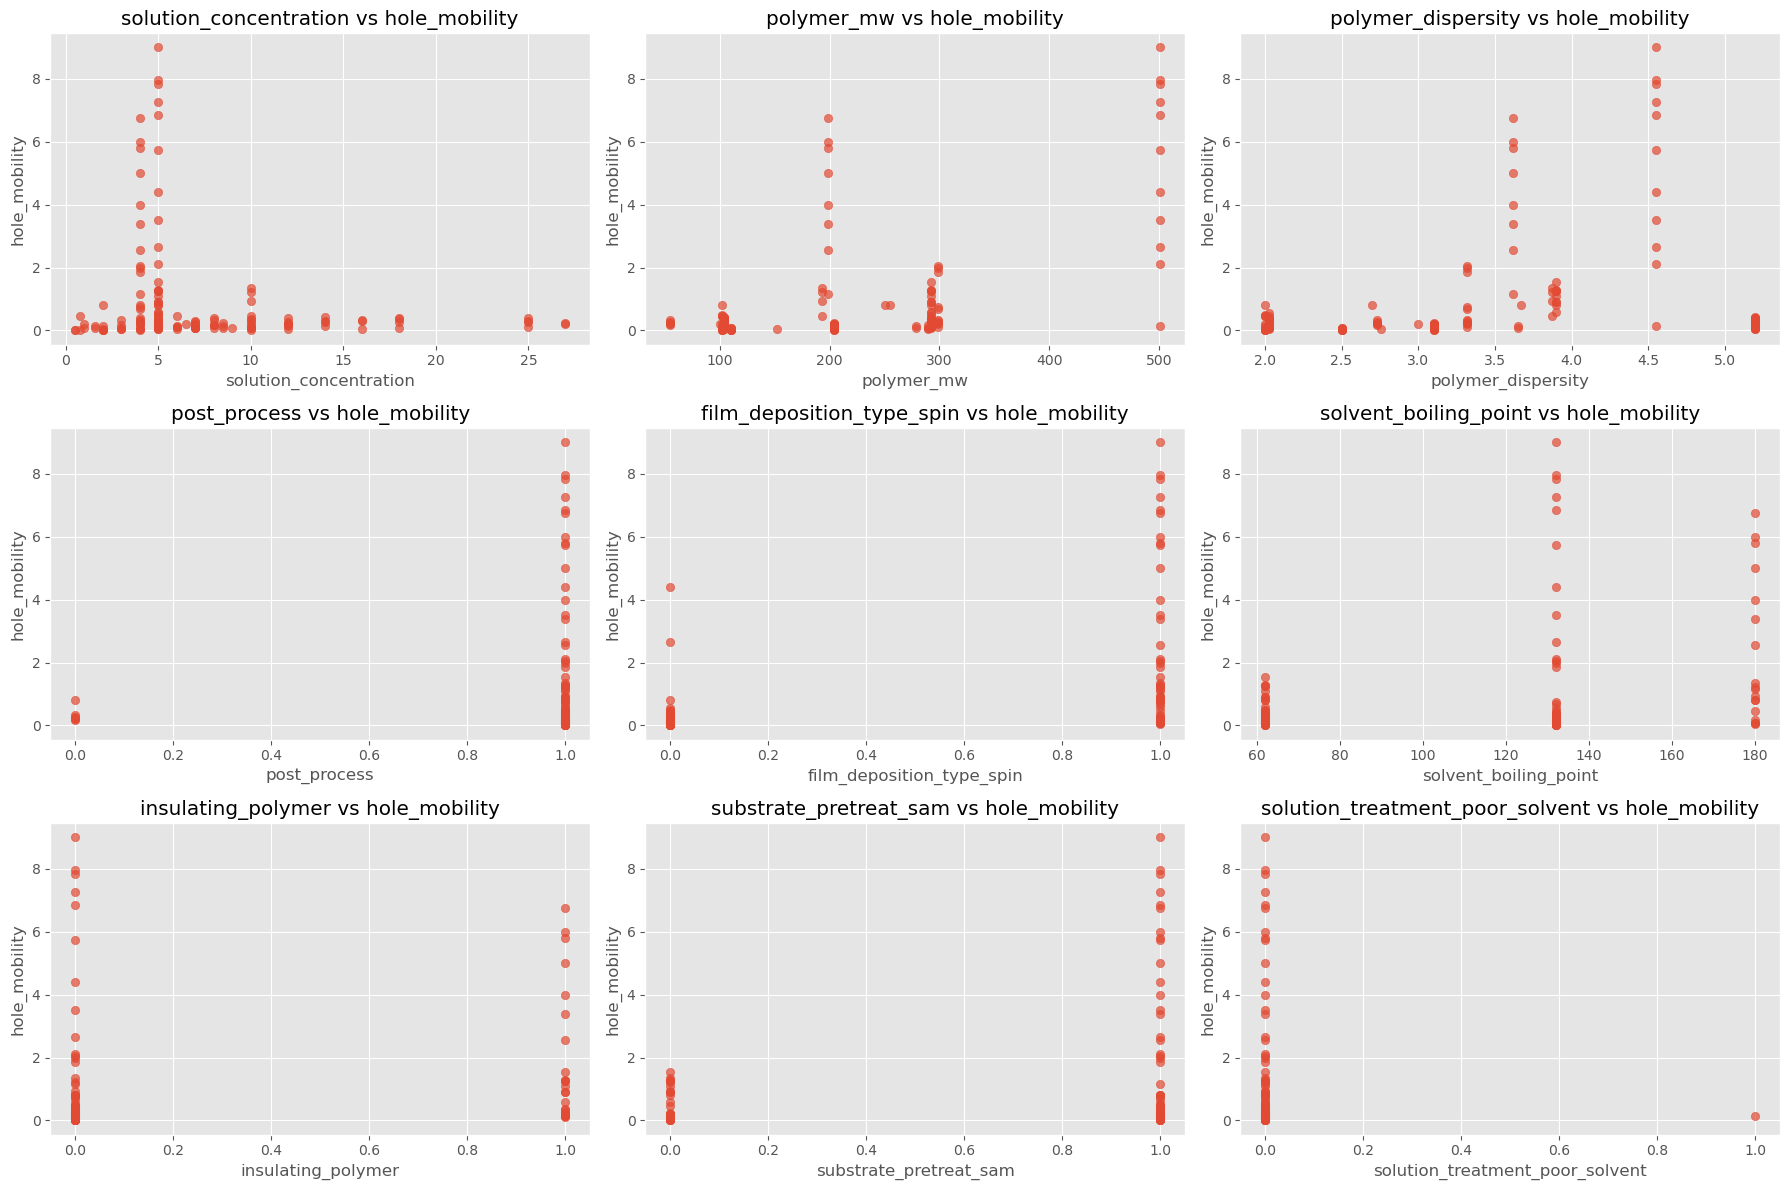

In [6]:
import matplotlib.pyplot as plt

# Define X columns (excluding "hole_mobility")
x_columns = df.columns[df.columns != "hole_mobility"]

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 12))  # Adjust based on number of X values
axes = axes.ravel()  # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(x_columns):
    axes[i].scatter(df[col], df["hole_mobility"], alpha=0.7)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("hole_mobility")
    axes[i].set_title(f"{col} vs hole_mobility")

plt.tight_layout()
plt.show()


## multicollinieary check

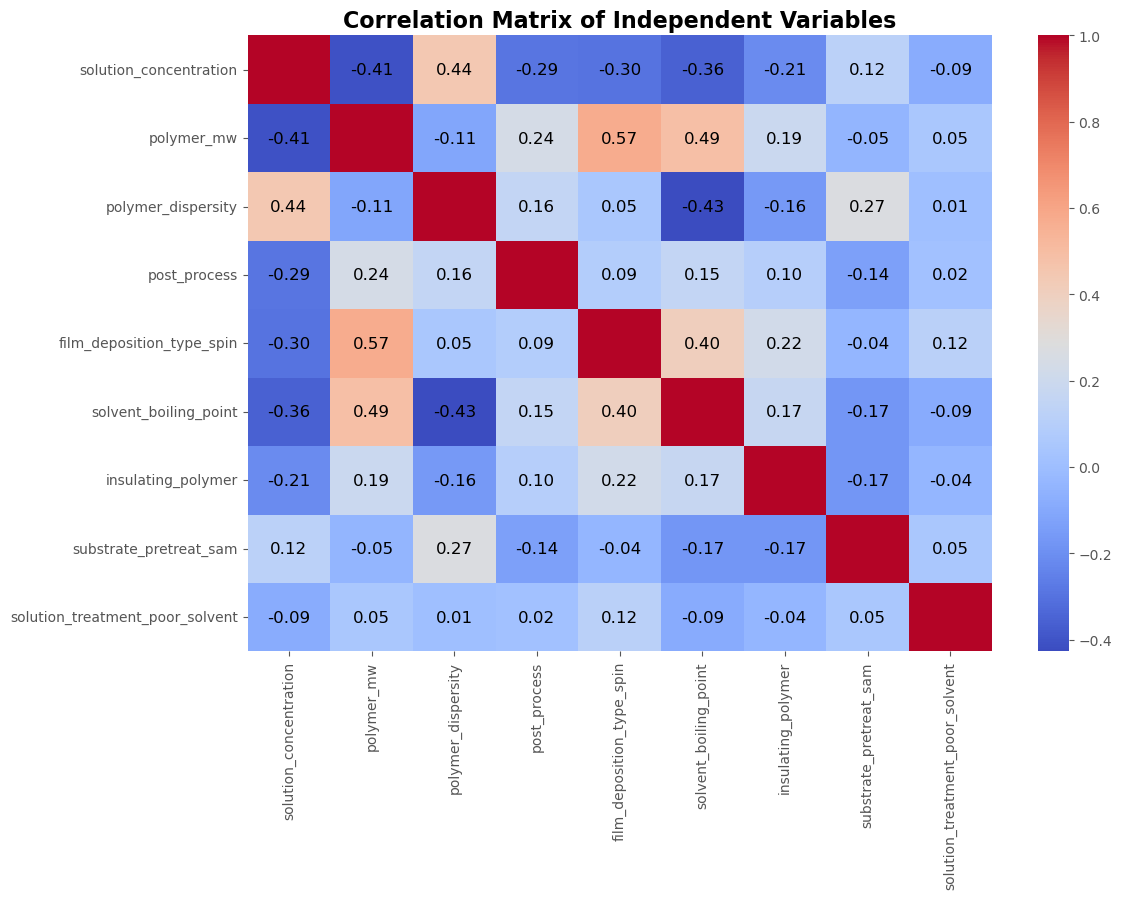

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate the correlation matrix
correlation_matrix = DPP_DTT_X.corr()

# Check for NaN values and fill them with zeros
if correlation_matrix.isna().sum().sum() > 0:
    correlation_matrix = correlation_matrix.fillna(0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(correlation_matrix, 
                      annot=False, 
                      fmt=".2f", 
                      cmap="coolwarm", 
                      cbar=True)

# Annotate only the non-zero and non-NaN correlations
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        corr_value = correlation_matrix.iloc[i, j]
        # Only annotate non-diagonal, non-zero, non-NaN values
        if i != j and not np.isnan(corr_value) and corr_value != 0:
            heatmap.text(j + 0.5, i + 0.5, 
                         f"{corr_value:.2f}", 
                         ha='center', 
                         va='center', 
                         color='black', 
                         fontsize=12, 
                         )

plt.title("Correlation Matrix of Independent Variables", fontsize=16, fontweight='bold')
plt.show()


## w/o strandardscale

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(DPP_DTT_X, DPP_DTT_Y, test_size = 0.3, random_state=42)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

## Linear regression

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

LR_model = LinearRegression()

LR_model.fit(X_train, y_train)

y_train_pred = LR_model.predict(X_train)
y_test_pred = LR_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"R² score for training set: {r2_train:.3f}")
print(f"R² score for test set: {r2_test:.3f}")

R² score for training set: 0.464
R² score for test set: 0.556


## Polynomial regression

Degree 1: R² train = 0.464, R² test = 0.556
Degree 2: R² train = 0.812, R² test = 0.703
Degree 3: R² train = 0.812, R² test = 0.564
Degree 4: R² train = 0.812, R² test = -18.392
Degree 5: R² train = 0.812, R² test = -608733402.800
Degree 6: R² train = 0.788, R² test = -23302627044852.324


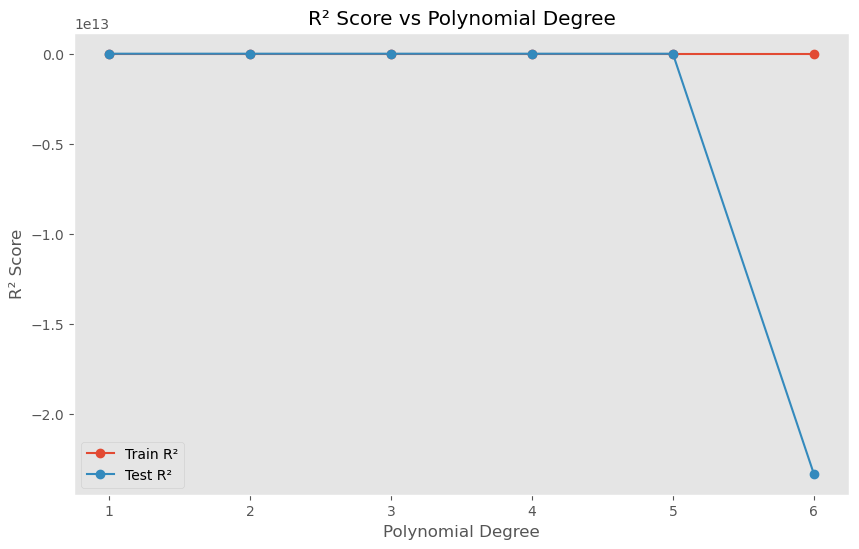

In [10]:
from sklearn.preprocessing import PolynomialFeatures

# Initialize lists to store R² scores
train_r2_scores = []
test_r2_scores = []
degrees = range(1, 7)

# Loop through degrees 1 to 6
for degree in degrees:
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    # Train the model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # Predict on training and test sets
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    
    # Calculate R² scores
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    # Append scores to the lists
    train_r2_scores.append(r2_train)
    test_r2_scores.append(r2_test)

# Print R² scores for each degree
for degree, r2_train, r2_test in zip(degrees, train_r2_scores, test_r2_scores):
    print(f"Degree {degree}: R² train = {r2_train:.3f}, R² test = {r2_test:.3f}")

# Plot the R² scores
plt.figure(figsize=(10, 6))
plt.plot(degrees, train_r2_scores, label='Train R²', marker='o')
plt.plot(degrees, test_r2_scores, label='Test R²', marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.title('R² Score vs Polynomial Degree')
plt.legend()
plt.grid()
plt.show()

## Ridge regression

Alpha 0.1: R² train = 0.464, R² test = 0.556
Alpha 0.2: R² train = 0.464, R² test = 0.556
Alpha 0.3: R² train = 0.464, R² test = 0.556
Alpha 0.4: R² train = 0.464, R² test = 0.556
Alpha 0.5: R² train = 0.463, R² test = 0.556
Alpha 0.6: R² train = 0.463, R² test = 0.556
Alpha 0.7: R² train = 0.463, R² test = 0.556
Alpha 0.8: R² train = 0.463, R² test = 0.556
Alpha 0.9: R² train = 0.463, R² test = 0.555
Alpha 1.0: R² train = 0.463, R² test = 0.555


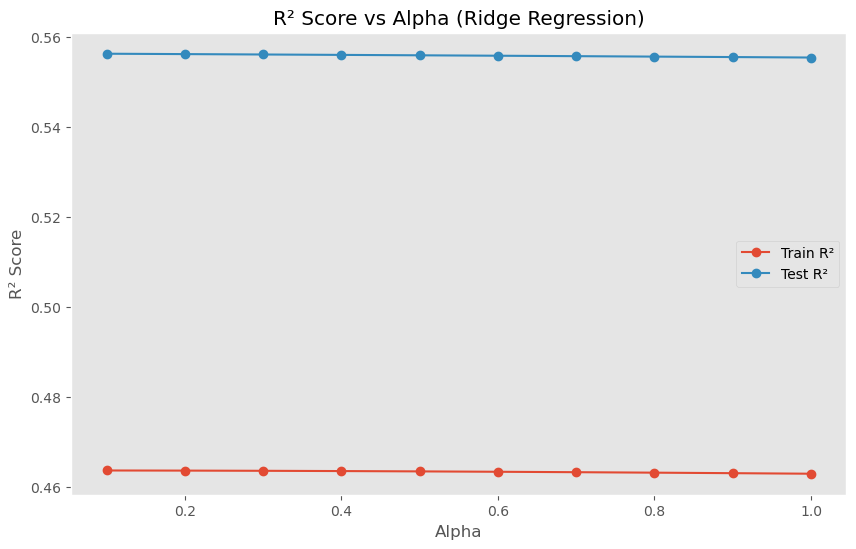

In [11]:
from sklearn.linear_model import Ridge

# Initialize lists to store R² scores
train_r2_scores = []
test_r2_scores = []
alphas = np.arange(0.1, 1.1, 0.1)

# Loop through alpha values
for alpha in alphas:
    # Train Ridge Regression model
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    
    # Predict on training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate R² scores
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    # Append scores to the lists
    train_r2_scores.append(r2_train)
    test_r2_scores.append(r2_test)

# Print R² scores for each alpha
for alpha, r2_train, r2_test in zip(alphas, train_r2_scores, test_r2_scores):
    print(f"Alpha {alpha:.1f}: R² train = {r2_train:.3f}, R² test = {r2_test:.3f}")

# Plot the R² scores
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_r2_scores, label='Train R²', marker='o')
plt.plot(alphas, test_r2_scores, label='Test R²', marker='o')
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title('R² Score vs Alpha (Ridge Regression)')
plt.legend()
plt.grid()
plt.show()

## Lasso regression

Alpha 0.1: R² train = 0.383, R² test = 0.475
Alpha 0.2: R² train = 0.367, R² test = 0.447
Alpha 0.3: R² train = 0.351, R² test = 0.425
Alpha 0.4: R² train = 0.329, R² test = 0.397
Alpha 0.5: R² train = 0.300, R² test = 0.362
Alpha 0.6: R² train = 0.294, R² test = 0.355
Alpha 0.7: R² train = 0.292, R² test = 0.354
Alpha 0.8: R² train = 0.291, R² test = 0.353
Alpha 0.9: R² train = 0.291, R² test = 0.353
Alpha 1.0: R² train = 0.291, R² test = 0.353


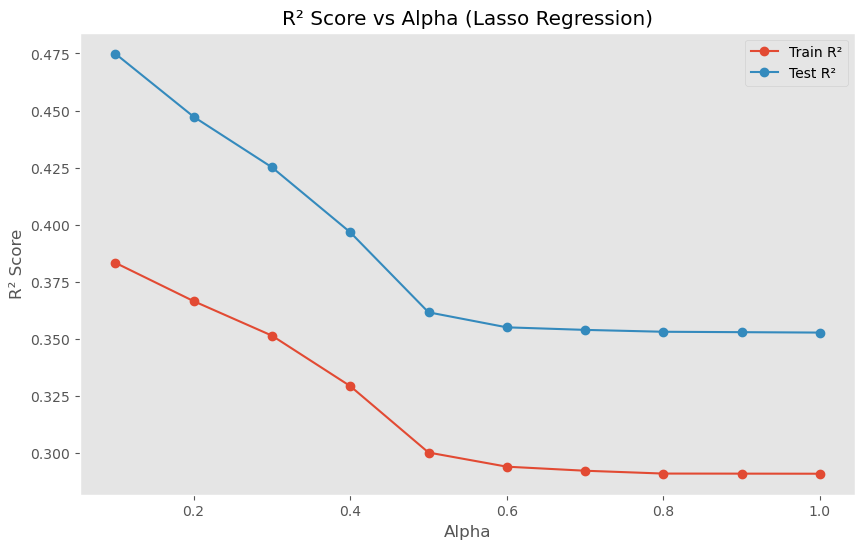

In [12]:
from sklearn.linear_model import Lasso

# Initialize lists to store R² scores
train_r2_scores = []
test_r2_scores = []
alphas = np.arange(0.1, 1.1, 0.1)

# Loop through alpha values
for alpha in alphas:
    # Train Lasso Regression model
    model = Lasso(alpha=alpha, max_iter=10000)  # Increased max_iter to ensure convergence
    model.fit(X_train, y_train)
    
    # Predict on training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate R² scores
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    # Append scores to the lists
    train_r2_scores.append(r2_train)
    test_r2_scores.append(r2_test)

# Print R² scores for each alpha
for alpha, r2_train, r2_test in zip(alphas, train_r2_scores, test_r2_scores):
    print(f"Alpha {alpha:.1f}: R² train = {r2_train:.3f}, R² test = {r2_test:.3f}")

# Plot the R² scores
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_r2_scores, label='Train R²', marker='o')
plt.plot(alphas, test_r2_scores, label='Test R²', marker='o')
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title('R² Score vs Alpha (Lasso Regression)')
plt.legend()
plt.grid()
plt.show()

## Elsaticnet regression

In [13]:
from sklearn.linear_model import ElasticNet

# Initialize lists to store results
results = []

# Alpha and l1_ratio ranges
alphas = np.arange(0.1, 1.1, 0.1)
l1_ratios = np.arange(0.1, 1.1, 0.1)

# Loop through alpha and l1_ratio values
for alpha in alphas:
    for l1_ratio in l1_ratios:
        # Train ElasticNet Regression model
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)
        model.fit(X_train, y_train)
        
        # Predict on training and test sets
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Calculate R² scores
        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)
        
        # Append results
        results.append({'alpha': alpha, 'l1_ratio': l1_ratio, 'r2_train': r2_train, 'r2_test': r2_test})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

# Find the row with the maximum R² score for training
max_train_r2 = results_df.loc[results_df['r2_train'].idxmax()]
print("Maximum Train R²:")
print(max_train_r2)

# Find the row with the maximum R² score for testing
max_test_r2 = results_df.loc[results_df['r2_test'].idxmax()]
print("\nMaximum Test R²:")
print(max_test_r2)

    alpha  l1_ratio  r2_train   r2_test
0     0.1       0.1  0.441339  0.537220
1     0.1       0.2  0.437312  0.533664
2     0.1       0.3  0.432434  0.529444
3     0.1       0.4  0.426469  0.524417
4     0.1       0.5  0.419085  0.518404
5     0.1       0.6  0.413009  0.511979
6     0.1       0.7  0.406351  0.504337
7     0.1       0.8  0.398152  0.494904
8     0.1       0.9  0.391124  0.485659
9     0.1       1.0  0.383313  0.474897
10    0.2       0.1  0.421004  0.515883
11    0.2       0.2  0.411162  0.506279
12    0.2       0.3  0.400274  0.494783
13    0.2       0.4  0.388839  0.481004
14    0.2       0.5  0.378682  0.466788
15    0.2       0.6  0.372015  0.457050
16    0.2       0.7  0.370860  0.454845
17    0.2       0.8  0.369568  0.452491
18    0.2       0.9  0.368127  0.449975
19    0.2       1.0  0.366522  0.447285
20    0.3       0.1  0.405730  0.498091
21    0.3       0.2  0.392179  0.483217
22    0.3       0.3  0.379037  0.466250
23    0.3       0.4  0.369078  0.451708


## Support Vector Regression (SVR)

In [14]:
from sklearn.svm import SVR

# Initialize lists to store results
results = []

# Range of C and epsilon values
C_values = np.arange(1, 7, 1)
epsilon_values = np.arange(0.1, 1.2, 0.1)

# Loop through C and epsilon values
for C in C_values:
    for epsilon in epsilon_values:
        # Train SVR model
        model = SVR(C=C, epsilon=epsilon)
        model.fit(X_train, y_train.ravel())  # Flatten y for SVR compatibility
        
        # Predict on training and test sets
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Calculate R² scores
        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)
        
        # Append results
        results.append({'C': C, 'epsilon': epsilon, 'r2_train': r2_train, 'r2_test': r2_test})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

# Find the best combination for training and testing
max_train_r2 = results_df.loc[results_df['r2_train'].idxmax()]
max_test_r2 = results_df.loc[results_df['r2_test'].idxmax()]

print("\nMaximum Train R²:")
print(max_train_r2)

print("\nMaximum Test R²:")
print(max_test_r2)

    C  epsilon  r2_train   r2_test
0   1      0.1  0.416990  0.469437
1   1      0.2  0.437303  0.484861
2   1      0.3  0.452950  0.495892
3   1      0.4  0.442521  0.488792
4   1      0.5  0.448233  0.493653
5   1      0.6  0.430193  0.480387
6   1      0.7  0.414784  0.468172
7   1      0.8  0.398144  0.453907
8   1      0.9  0.385304  0.443063
9   1      1.0  0.365798  0.426269
10  1      1.1  0.340687  0.404082
11  2      0.1  0.473676  0.504256
12  2      0.2  0.495388  0.517897
13  2      0.3  0.499158  0.516919
14  2      0.4  0.516659  0.526181
15  2      0.5  0.518969  0.523426
16  2      0.6  0.522802  0.520999
17  2      0.7  0.525250  0.517415
18  2      0.8  0.518497  0.506095
19  2      0.9  0.505857  0.489226
20  2      1.0  0.489100  0.469170
21  2      1.1  0.463297  0.440581
22  3      0.1  0.515860  0.501754
23  3      0.2  0.525268  0.509975
24  3      0.3  0.529512  0.510414
25  3      0.4  0.538061  0.510716
26  3      0.5  0.540076  0.499922
27  3      0.6  0.54

## Decision tree regression

In [15]:
from sklearn.tree import DecisionTreeRegressor

# Initialize the Decision Tree Regressor
model = DecisionTreeRegressor()

# Train the model
model.fit(X_train, y_train)

# Predict on training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate R² scores
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the R² scores
print(f"R² score for training set: {r2_train:.3f}")
print(f"R² score for test set: {r2_test:.3f}")

R² score for training set: 0.812
R² score for test set: 0.739


## Random forest regression

In [16]:
from sklearn.ensemble import RandomForestRegressor

# Initialize lists to store results
results = []

# Range of n_estimators
n_estimators_range = range(100, 401, 10)

# Loop through n_estimators values
for n_estimators in n_estimators_range:
    # Train Random Forest Regressor
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train.ravel())  # Flatten y for compatibility
    
    # Predict on training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate R² scores
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    # Append results
    results.append({'n_estimators': n_estimators, 'r2_train': r2_train, 'r2_test': r2_test})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results
print("Top 10 configurations by Test R²:")
print(results_df.sort_values(by='r2_test', ascending=False).head(10))

Top 10 configurations by Test R²:
   n_estimators  r2_train   r2_test
0           100  0.808563  0.747664
1           110  0.807959  0.747338
2           120  0.808392  0.746986
3           130  0.809362  0.745498
4           140  0.809634  0.743497
6           160  0.809894  0.741031
5           150  0.809865  0.739895
7           170  0.809675  0.739574
8           180  0.810060  0.739060
9           190  0.810227  0.736865


## Gradient bossting regression

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize lists to store results
results = []

# Hyperparameter ranges
n_estimators_range = range(100, 311, 10)
learning_rate_range = np.arange(0.1, 1.1, 0.1)
max_depth_range = range(1, 16)

# Perform grid search over hyperparameters
for n_estimators in n_estimators_range:
    for learning_rate in learning_rate_range:
        for max_depth in max_depth_range:
            # Train Gradient Boosting Regressor
            model = GradientBoostingRegressor(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth
            )
            model.fit(X_train, y_train.ravel())  # Flatten y for compatibility
            
            # Predict on training and test sets
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            
            # Calculate R² scores
            r2_train = r2_score(y_train, y_train_pred)
            r2_test = r2_score(y_test, y_test_pred)
            
            # Append results
            results.append({
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'r2_train': r2_train,
                'r2_test': r2_test
            })

# Print the top results sorted by test R²
print("Top 10 configurations by Test R²:")
print(results_df.sort_values(by='r2_test', ascending=False).head(10))

Top 10 configurations by Test R²:
   n_estimators  r2_train   r2_test
0           100  0.808563  0.747664
1           110  0.807959  0.747338
2           120  0.808392  0.746986
3           130  0.809362  0.745498
4           140  0.809634  0.743497
6           160  0.809894  0.741031
5           150  0.809865  0.739895
7           170  0.809675  0.739574
8           180  0.810060  0.739060
9           190  0.810227  0.736865


## K-nearest Neighbors Regression

In [18]:
from sklearn.neighbors import KNeighborsRegressor

# Initialize lists to store results
results = []

# Range of n_neighbors
n_neighbors_range = range(1, 17)

# Loop through n_neighbors values
for n_neighbors in n_neighbors_range:
    # Train K-Nearest Neighbors Regressor
    model = KNeighborsRegressor(n_neighbors=n_neighbors)
    model.fit(X_train, y_train.ravel())  # Flatten y for compatibility
    
    # Predict on training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate R² scores
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    # Append results
    results.append({'n_neighbors': n_neighbors, 'r2_train': r2_train, 'r2_test': r2_test})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results
print("Top configurations by Test R²:")
print(results_df.sort_values(by='r2_test', ascending=False).head(10))

Top configurations by Test R²:
    n_neighbors  r2_train   r2_test
6             7  0.721955  0.663432
7             8  0.674568  0.659883
2             3  0.793019  0.655530
8             9  0.623397  0.643637
3             4  0.803142  0.634593
5             6  0.771495  0.622331
9            10  0.593187  0.618674
4             5  0.788548  0.604168
1             2  0.731910  0.599489
10           11  0.566826  0.592322


## XGB regression

In [19]:
from xgboost import XGBRegressor

# Initialize lists to store results
results = []

# Hyperparameter ranges
n_estimators_range = range(100, 311, 10)
learning_rate_range = np.arange(0.1, 1.1, 0.1)
max_depth_range = range(1, 17)

# Perform grid search over hyperparameters
for n_estimators in n_estimators_range:
    for learning_rate in learning_rate_range:
        for max_depth in max_depth_range:
            # Train XGBoost Regressor
            model = XGBRegressor(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                random_state=42
            )
            model.fit(X_train, y_train.ravel())  # Flatten y for compatibility
            
            # Predict on training and test sets
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            
            # Calculate R² scores
            r2_train = r2_score(y_train, y_train_pred)
            r2_test = r2_score(y_test, y_test_pred)
            
            # Append results
            results.append({
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'r2_train': r2_train,
                'r2_test': r2_test
            })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the top 10 configurations sorted by test R²
print("Top 10 configurations by Test R²:")
print(results_df.sort_values(by='r2_test', ascending=False).head(10))

Top 10 configurations by Test R²:
      n_estimators  learning_rate  max_depth  r2_train   r2_test
2242           240            0.1          3  0.812349  0.740760
2082           230            0.1          3  0.812346  0.740756
2402           250            0.1          3  0.812356  0.740749
2562           260            0.1          3  0.812362  0.740732
2578           260            0.2          3  0.812425  0.740719
3378           310            0.2          3  0.812425  0.740719
3218           300            0.2          3  0.812425  0.740719
2898           280            0.2          3  0.812425  0.740719
3058           290            0.2          3  0.812425  0.740719
2738           270            0.2          3  0.812425  0.740719


## Adaboost regression

In [20]:
from sklearn.ensemble import AdaBoostRegressor

# Initialize lists to store results
results = []

# Hyperparameter ranges
n_estimators_range = range(100, 311, 10)
learning_rate_range = np.arange(0.1, 1.1, 0.1)
max_depth_range = range(1, 17)

# Perform grid search over hyperparameters
for n_estimators in n_estimators_range:
    for learning_rate in learning_rate_range:
        for max_depth in max_depth_range:
            # Define the AdaBoost model with a DecisionTreeRegressor as the base learner
            model = AdaBoostRegressor(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                random_state=42
            )
            
            # Train the model
            model.fit(X_train, y_train.ravel())
            
            # Predict on training and test sets
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            
            # Calculate R² scores
            r2_train = r2_score(y_train, y_train_pred)
            r2_test = r2_score(y_test, y_test_pred)
            
            # Append results
            results.append({
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'r2_train': r2_train,
                'r2_test': r2_test
            })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the top 10 configurations sorted by test R²

print("Top 10 configurations by Test R²:")
print(results_df.sort_values(by='r2_test', ascending=False).head(10))

Top 10 configurations by Test R²:
      n_estimators  learning_rate  max_depth  r2_train   r2_test
288            110            0.9          1  0.776372  0.755908
2696           260            0.9          9  0.776372  0.755908
290            110            0.9          3  0.776372  0.755908
289            110            0.9          2  0.776372  0.755908
461            120            0.9         14  0.776372  0.755908
2215           230            0.9          8  0.776372  0.755908
2216           230            0.9          9  0.776372  0.755908
2217           230            0.9         10  0.776372  0.755908
2218           230            0.9         11  0.776372  0.755908
2219           230            0.9         12  0.776372  0.755908


## K-fold validation with Adabossting regression

In [21]:
from sklearn.model_selection import KFold

# Range of K-Fold splits to evaluate
k_values = range(2, 11)  # From K=2 to K=10 (K=1 is invalid for cross-validation)

# Lists to store results for each K
results = []

# Iterate over different K values
for k in k_values:
    # Initialize K-Fold Cross-Validation
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    # Initialize lists to store R² scores for this K
    train_r2_scores = []
    test_r2_scores = []
    
    # Define the AdaBoost Regressor
    model = AdaBoostRegressor(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    )
    
    # Perform cross-validation
    for train_index, test_index in kf.split(DPP_DTT_X):
        # Split data into training and test sets
        X_train, X_test = DPP_DTT_X.iloc[train_index], DPP_DTT_X.iloc[test_index]
        y_train, y_test = DPP_DTT_Y.iloc[train_index], DPP_DTT_Y.iloc[test_index]
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on training and test sets
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Calculate R² scores
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        # Append scores
        train_r2_scores.append(train_r2)
        test_r2_scores.append(test_r2)
    
    # Store average R² scores for this K
    results.append({
        'K': k,
        'Avg Train R²': np.mean(train_r2_scores),
        'Avg Test R²': np.mean(test_r2_scores)
    })

# Convert results to a DataFrame for better readability
results_df = pd.DataFrame(results)

# Print the results
print("K-Fold Cross-Validation Results:")
print(results_df)

C:\Users\Myeongyeon Lee\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Myeongyeon Lee\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Myeongyeon Lee\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Myeongyeon Lee\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

K-Fold Cross-Validation Results:
    K  Avg Train R²  Avg Test R²
0   2      0.823740     0.677670
1   3      0.785533     0.770466
2   4      0.785668     0.780948
3   5      0.783541     0.748757
4   6      0.781494     0.696720
5   7      0.781461     0.681043
6   8      0.781020     0.715883
7   9      0.778590     0.672144
8  10      0.779740     0.514409


## Important x values from adaboosting regresion

In [22]:
# Example dataset (replace with your actual dataset)
X_train, X_test, y_train, y_test = train_test_split(DPP_DTT_X, DPP_DTT_Y, test_size = 0.2, random_state=42)
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Train AdaBoost Regressor
model = AdaBoostRegressor(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': DPP_DTT_X.columns,
    'Importance': feature_importances
})

# Sort features by importance (descending order)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the sorted feature importances
print("Feature Importance (Descending Order):")
print(importance_df)

Feature Importance (Descending Order):
                           Feature  Importance
1                       polymer_mw    0.590273
5            solvent_boiling_point    0.136757
6               insulating_polymer    0.115235
4        film_deposition_type_spin    0.095113
2               polymer_dispersity    0.047004
7           substrate_pretreat_sam    0.009256
0           solution_concentration    0.006362
3                     post_process    0.000000
8  solution_treatment_poor_solvent    0.000000


C:\Users\Myeongyeon Lee\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## w/ Stnadard scaler only X

In [23]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

In [24]:
print(X_train.mean())
print(X_train.std())
print(X_test.mean())
print(X_test.std())
print(y_train.mean())
print(y_train.std())
print(y_test.mean())
print(y_test.std())

-6.443167599293838e-17
1.0
0.023966041918706535
0.8862683744327745
0.9459051502314049
1.8709501987623551
0.7045943373225805
1.2123500294196865


## Linear regression

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

LR_model = LinearRegression()

LR_model.fit(X_train, y_train)

y_train_pred = LR_model.predict(X_train)
y_test_pred = LR_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"R² score for training set: {r2_train:.3f}")
print(f"R² score for test set: {r2_test:.3f}")

R² score for training set: 0.517
R² score for test set: 0.249


## Polynomial regression

Degree 1: R² train = 0.517, R² test = 0.249
Degree 2: R² train = 0.358, R² test = -2724970888629614280704.000
Degree 3: R² train = 0.830, R² test = 0.340
Degree 4: R² train = 0.830, R² test = -2450659674001.667
Degree 5: R² train = 0.830, R² test = -559586.479
Degree 6: R² train = 0.830, R² test = -188526.849


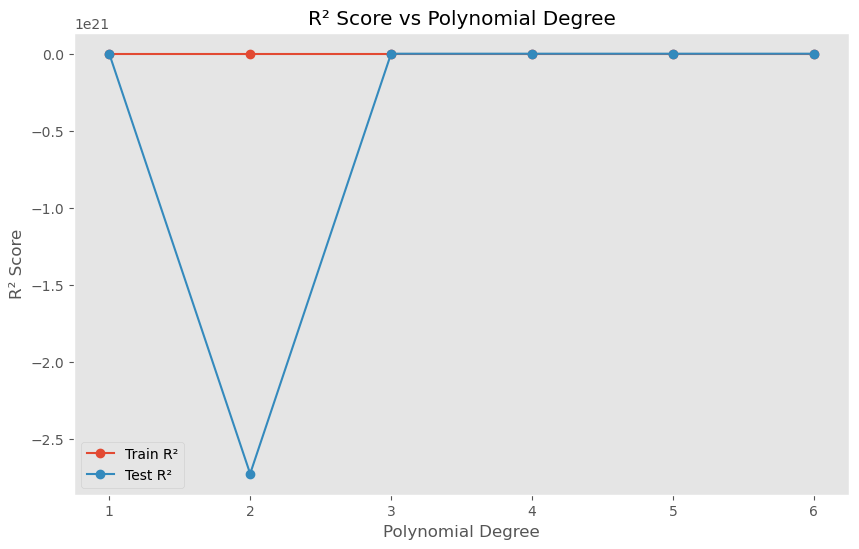

In [26]:
from sklearn.preprocessing import PolynomialFeatures

# Initialize lists to store R² scores
train_r2_scores = []
test_r2_scores = []
degrees = range(1, 7)

# Loop through degrees 1 to 6
for degree in degrees:
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    # Train the model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # Predict on training and test sets
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    
    # Calculate R² scores
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    # Append scores to the lists
    train_r2_scores.append(r2_train)
    test_r2_scores.append(r2_test)

# Print R² scores for each degree
for degree, r2_train, r2_test in zip(degrees, train_r2_scores, test_r2_scores):
    print(f"Degree {degree}: R² train = {r2_train:.3f}, R² test = {r2_test:.3f}")

# Plot the R² scores
plt.figure(figsize=(10, 6))
plt.plot(degrees, train_r2_scores, label='Train R²', marker='o')
plt.plot(degrees, test_r2_scores, label='Test R²', marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.title('R² Score vs Polynomial Degree')
plt.legend()
plt.grid()
plt.show()

## Ridge regression

Alpha 0.1: R² train = 0.517, R² test = 0.250
Alpha 0.2: R² train = 0.517, R² test = 0.250
Alpha 0.3: R² train = 0.517, R² test = 0.251
Alpha 0.4: R² train = 0.517, R² test = 0.251
Alpha 0.5: R² train = 0.517, R² test = 0.252
Alpha 0.6: R² train = 0.517, R² test = 0.252
Alpha 0.7: R² train = 0.517, R² test = 0.252
Alpha 0.8: R² train = 0.517, R² test = 0.253
Alpha 0.9: R² train = 0.517, R² test = 0.253
Alpha 1.0: R² train = 0.517, R² test = 0.254


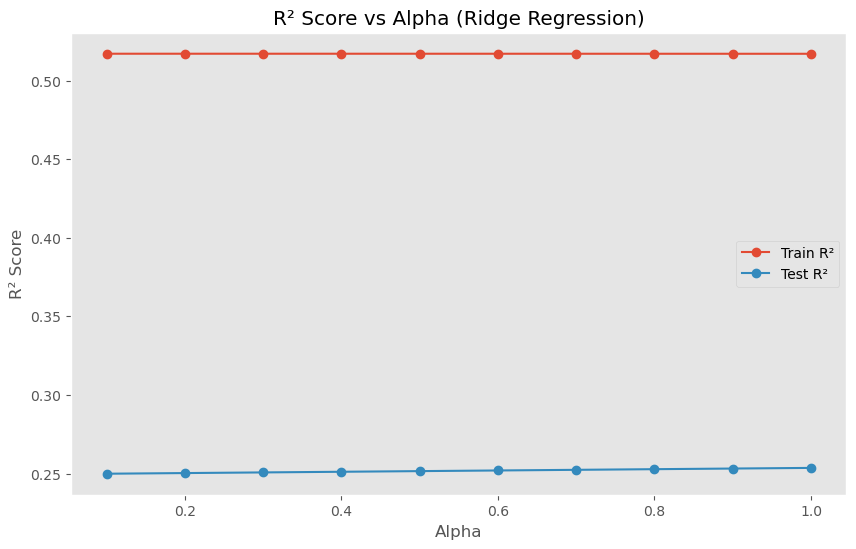

In [27]:
from sklearn.linear_model import Ridge

# Initialize lists to store R² scores
train_r2_scores = []
test_r2_scores = []
alphas = np.arange(0.1, 1.1, 0.1)

# Loop through alpha values
for alpha in alphas:
    # Train Ridge Regression model
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    
    # Predict on training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate R² scores
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    # Append scores to the lists
    train_r2_scores.append(r2_train)
    test_r2_scores.append(r2_test)

# Print R² scores for each alpha
for alpha, r2_train, r2_test in zip(alphas, train_r2_scores, test_r2_scores):
    print(f"Alpha {alpha:.1f}: R² train = {r2_train:.3f}, R² test = {r2_test:.3f}")

# Plot the R² scores
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_r2_scores, label='Train R²', marker='o')
plt.plot(alphas, test_r2_scores, label='Test R²', marker='o')
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title('R² Score vs Alpha (Ridge Regression)')
plt.legend()
plt.grid()
plt.show()

## Lasso regression

Alpha 0.1: R² train = 0.490, R² test = 0.264
Alpha 0.2: R² train = 0.439, R² test = 0.237
Alpha 0.3: R² train = 0.395, R² test = 0.227
Alpha 0.4: R² train = 0.345, R² test = 0.208
Alpha 0.5: R² train = 0.304, R² test = 0.197
Alpha 0.6: R² train = 0.263, R² test = 0.176
Alpha 0.7: R² train = 0.216, R² test = 0.138
Alpha 0.8: R² train = 0.163, R² test = 0.088
Alpha 0.9: R² train = 0.114, R² test = 0.057
Alpha 1.0: R² train = 0.060, R² test = 0.014


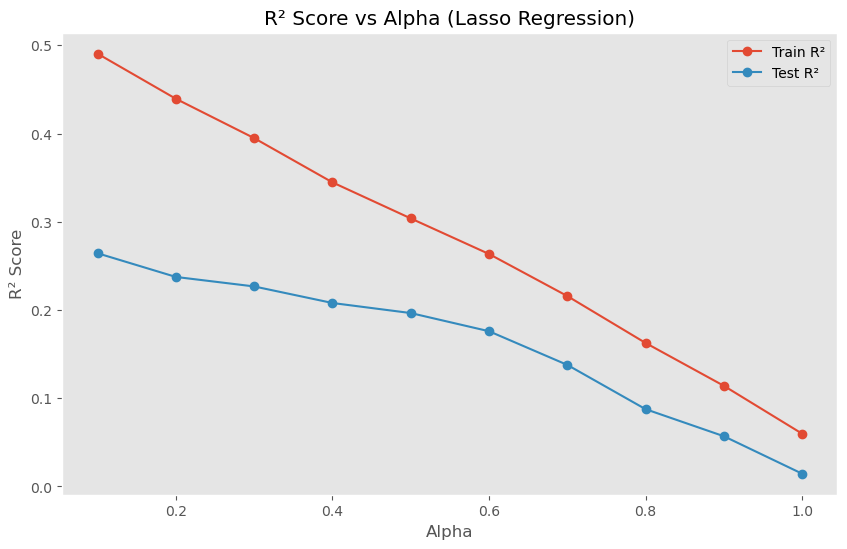

In [28]:
from sklearn.linear_model import Lasso

# Initialize lists to store R² scores
train_r2_scores = []
test_r2_scores = []
alphas = np.arange(0.1, 1.1, 0.1)

# Loop through alpha values
for alpha in alphas:
    # Train Lasso Regression model
    model = Lasso(alpha=alpha, max_iter=10000)  # Increased max_iter to ensure convergence
    model.fit(X_train, y_train)
    
    # Predict on training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate R² scores
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    # Append scores to the lists
    train_r2_scores.append(r2_train)
    test_r2_scores.append(r2_test)

# Print R² scores for each alpha
for alpha, r2_train, r2_test in zip(alphas, train_r2_scores, test_r2_scores):
    print(f"Alpha {alpha:.1f}: R² train = {r2_train:.3f}, R² test = {r2_test:.3f}")

# Plot the R² scores
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_r2_scores, label='Train R²', marker='o')
plt.plot(alphas, test_r2_scores, label='Test R²', marker='o')
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title('R² Score vs Alpha (Lasso Regression)')
plt.legend()
plt.grid()
plt.show()

## Elsaticnet regression

In [29]:
from sklearn.linear_model import ElasticNet

# Initialize lists to store results
results = []

# Alpha and l1_ratio ranges
alphas = np.arange(0.1, 1.1, 0.1)
l1_ratios = np.arange(0.1, 1.1, 0.1)

# Loop through alpha and l1_ratio values
for alpha in alphas:
    for l1_ratio in l1_ratios:
        # Train ElasticNet Regression model
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)
        model.fit(X_train, y_train)
        
        # Predict on training and test sets
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Calculate R² scores
        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)
        
        # Append results
        results.append({'alpha': alpha, 'l1_ratio': l1_ratio, 'r2_train': r2_train, 'r2_test': r2_test})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

# Find the row with the maximum R² score for training
max_train_r2 = results_df.loc[results_df['r2_train'].idxmax()]
print("Maximum Train R²:")
print(max_train_r2)

# Find the row with the maximum R² score for testing
max_test_r2 = results_df.loc[results_df['r2_test'].idxmax()]
print("\nMaximum Test R²:")
print(max_test_r2)

    alpha  l1_ratio  r2_train   r2_test
0     0.1       0.1  0.512312  0.292127
1     0.1       0.2  0.510884  0.290379
2     0.1       0.3  0.509075  0.287870
3     0.1       0.4  0.506839  0.284496
4     0.1       0.5  0.504625  0.281550
5     0.1       0.6  0.502482  0.279211
6     0.1       0.7  0.500019  0.276359
7     0.1       0.8  0.497214  0.272939
8     0.1       0.9  0.494036  0.268938
9     0.1       1.0  0.490460  0.264293
10    0.2       0.1  0.502261  0.322936
11    0.2       0.2  0.497532  0.318743
12    0.2       0.3  0.492417  0.314546
13    0.2       0.4  0.486487  0.309499
14    0.2       0.5  0.479326  0.302786
15    0.2       0.6  0.472291  0.295030
16    0.2       0.7  0.465171  0.285731
17    0.2       0.8  0.456855  0.273950
18    0.2       0.9  0.448550  0.257192
19    0.2       1.0  0.439367  0.237463
20    0.3       0.1  0.489769  0.344127
21    0.3       0.2  0.481270  0.337821
22    0.3       0.3  0.471256  0.329948
23    0.3       0.4  0.461655  0.320936


## Support Vector Regression (SVR)

In [30]:
from sklearn.svm import SVR

# Initialize lists to store results
results = []

# Range of C and epsilon values
C_values = np.arange(1, 7, 1)
epsilon_values = np.arange(0.1, 1.2, 0.1)

# Loop through C and epsilon values
for C in C_values:
    for epsilon in epsilon_values:
        # Train SVR model
        model = SVR(C=C, epsilon=epsilon)
        model.fit(X_train, y_train.ravel())  # Flatten y for SVR compatibility
        
        # Predict on training and test sets
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Calculate R² scores
        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)
        
        # Append results
        results.append({'C': C, 'epsilon': epsilon, 'r2_train': r2_train, 'r2_test': r2_test})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

# Find the best combination for training and testing
max_train_r2 = results_df.loc[results_df['r2_train'].idxmax()]
max_test_r2 = results_df.loc[results_df['r2_test'].idxmax()]

print("\nMaximum Train R²:")
print(max_train_r2)

print("\nMaximum Test R²:")
print(max_test_r2)

    C  epsilon  r2_train   r2_test
0   1      0.1  0.697868  0.718245
1   1      0.2  0.705997  0.709620
2   1      0.3  0.708491  0.670336
3   1      0.4  0.704458  0.625430
4   1      0.5  0.706759  0.597270
5   1      0.6  0.704339  0.564251
6   1      0.7  0.693166  0.531874
7   1      0.8  0.669061  0.466785
8   1      0.9  0.645710  0.390863
9   1      1.0  0.619428  0.327565
10  1      1.1  0.588540  0.249216
11  2      0.1  0.802792  0.445385
12  2      0.2  0.806329  0.425703
13  2      0.3  0.806207  0.399630
14  2      0.4  0.798017  0.343981
15  2      0.5  0.790370  0.302972
16  2      0.6  0.781808  0.288682
17  2      0.7  0.769857  0.294138
18  2      0.8  0.755382  0.272856
19  2      0.9  0.737928  0.232181
20  2      1.0  0.711953  0.171388
21  2      1.1  0.671343  0.084935
22  3      0.1  0.818695  0.352572
23  3      0.2  0.815662  0.309627
24  3      0.3  0.810042  0.278803
25  3      0.4  0.805762  0.261342
26  3      0.5  0.800205  0.253894
27  3      0.6  0.79

## Decision tree regression

In [31]:
from sklearn.tree import DecisionTreeRegressor

# Initialize the Decision Tree Regressor
model = DecisionTreeRegressor()

# Train the model
model.fit(X_train, y_train)

# Predict on training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate R² scores
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the R² scores
print(f"R² score for training set: {r2_train:.3f}")
print(f"R² score for test set: {r2_test:.3f}")

R² score for training set: 0.830
R² score for test set: 0.347


## Random forest regression

In [32]:
from sklearn.ensemble import RandomForestRegressor

# Initialize lists to store results
results = []

# Range of n_estimators
n_estimators_range = range(100, 401, 10)

# Loop through n_estimators values
for n_estimators in n_estimators_range:
    # Train Random Forest Regressor
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train.ravel())  # Flatten y for compatibility
    
    # Predict on training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate R² scores
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    # Append results
    results.append({'n_estimators': n_estimators, 'r2_train': r2_train, 'r2_test': r2_test})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results
print("Top 10 configurations by Test R²:")
print(results_df.sort_values(by='r2_test', ascending=False).head(10))

Top 10 configurations by Test R²:
    n_estimators  r2_train   r2_test
26           360  0.828356  0.359013
25           350  0.828335  0.358900
27           370  0.828383  0.357435
24           340  0.828250  0.356018
28           380  0.828319  0.355595
21           310  0.828279  0.353805
29           390  0.828278  0.353770
30           400  0.828331  0.353289
23           330  0.828231  0.352651
22           320  0.828328  0.351572


## Gradient bossting regression

In [33]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize lists to store results
results = []

# Hyperparameter ranges
n_estimators_range = range(100, 311, 10)
learning_rate_range = np.arange(0.1, 1.1, 0.1)
max_depth_range = range(1, 16)

# Perform grid search over hyperparameters
for n_estimators in n_estimators_range:
    for learning_rate in learning_rate_range:
        for max_depth in max_depth_range:
            # Train Gradient Boosting Regressor
            model = GradientBoostingRegressor(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth
            )
            model.fit(X_train, y_train.ravel())  # Flatten y for compatibility
            
            # Predict on training and test sets
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            
            # Calculate R² scores
            r2_train = r2_score(y_train, y_train_pred)
            r2_test = r2_score(y_test, y_test_pred)
            
            # Append results
            results.append({
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'r2_train': r2_train,
                'r2_test': r2_test
            })

# Print the top results sorted by test R²
print("Top 10 configurations by Test R²:")
print(results_df.sort_values(by='r2_test', ascending=False).head(10))

Top 10 configurations by Test R²:
    n_estimators  r2_train   r2_test
26           360  0.828356  0.359013
25           350  0.828335  0.358900
27           370  0.828383  0.357435
24           340  0.828250  0.356018
28           380  0.828319  0.355595
21           310  0.828279  0.353805
29           390  0.828278  0.353770
30           400  0.828331  0.353289
23           330  0.828231  0.352651
22           320  0.828328  0.351572


## K-nearest Neighbors Regression

In [34]:
from sklearn.neighbors import KNeighborsRegressor

# Initialize lists to store results
results = []

# Range of n_neighbors
n_neighbors_range = range(1, 17)

# Loop through n_neighbors values
for n_neighbors in n_neighbors_range:
    # Train K-Nearest Neighbors Regressor
    model = KNeighborsRegressor(n_neighbors=n_neighbors)
    model.fit(X_train, y_train.ravel())  # Flatten y for compatibility
    
    # Predict on training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate R² scores
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    # Append results
    results.append({'n_neighbors': n_neighbors, 'r2_train': r2_train, 'r2_test': r2_test})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results
print("Top configurations by Test R²:")
print(results_df.sort_values(by='r2_test', ascending=False).head(10))

Top configurations by Test R²:
    n_neighbors  r2_train   r2_test
11           12  0.622576  0.563464
13           14  0.569965  0.559169
12           13  0.585706  0.552137
10           11  0.671771  0.551224
3             4  0.797990  0.550191
15           16  0.497198  0.549163
9            10  0.690803  0.545678
0             1  0.785036  0.543855
14           15  0.528239  0.540192
8             9  0.720958  0.496741


## XGBregression

In [35]:
from xgboost import XGBRegressor

# Initialize lists to store results
results = []

# Hyperparameter ranges
n_estimators_range = range(100, 311, 10)
learning_rate_range = np.arange(0.1, 1.1, 0.1)
max_depth_range = range(1, 17)

# Perform grid search over hyperparameters
for n_estimators in n_estimators_range:
    for learning_rate in learning_rate_range:
        for max_depth in max_depth_range:
            # Train XGBoost Regressor
            model = XGBRegressor(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                random_state=42
            )
            model.fit(X_train, y_train.ravel())  # Flatten y for compatibility
            
            # Predict on training and test sets
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            
            # Calculate R² scores
            r2_train = r2_score(y_train, y_train_pred)
            r2_test = r2_score(y_test, y_test_pred)
            
            # Append results
            results.append({
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'r2_train': r2_train,
                'r2_test': r2_test
            })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the top 10 configurations sorted by test R²
print("Top 10 configurations by Test R²:")
print(results_df.sort_values(by='r2_test', ascending=False).head(10))

Top 10 configurations by Test R²:
      n_estimators  learning_rate  max_depth  r2_train   r2_test
162            110            0.1          3  0.829460  0.350879
322            120            0.1          3  0.829509  0.350678
2              100            0.1          3  0.829391  0.350649
482            130            0.1          3  0.829558  0.350111
642            140            0.1          3  0.829604  0.349352
802            150            0.1          3  0.829653  0.349190
1922           220            0.1          3  0.829753  0.348918
18             100            0.2          3  0.829744  0.348848
2082           230            0.1          3  0.829758  0.348825
962            160            0.1          3  0.829678  0.348701


## Adaboost regression

In [36]:
from sklearn.ensemble import AdaBoostRegressor

# Initialize lists to store results
results = []

# Hyperparameter ranges
n_estimators_range = range(100, 311, 10)
learning_rate_range = np.arange(0.1, 1.1, 0.1)
max_depth_range = range(1, 17)

# Perform grid search over hyperparameters
for n_estimators in n_estimators_range:
    for learning_rate in learning_rate_range:
        for max_depth in max_depth_range:
            # Define the AdaBoost model with a DecisionTreeRegressor as the base learner
            model = AdaBoostRegressor(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                random_state=42
            )
            
            # Train the model
            model.fit(X_train, y_train.ravel())
            
            # Predict on training and test sets
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            
            # Calculate R² scores
            r2_train = r2_score(y_train, y_train_pred)
            r2_test = r2_score(y_test, y_test_pred)
            
            # Append results
            results.append({
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'r2_train': r2_train,
                'r2_test': r2_test
            })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the top 10 configurations sorted by test R²

print("Top 10 configurations by Test R²:")
print(results_df.sort_values(by='r2_test', ascending=False).head(10))

Top 10 configurations by Test R²:
      n_estimators  learning_rate  max_depth  r2_train   r2_test
0              100            0.1          1  0.772376  0.749187
321            120            0.1          2  0.772376  0.749187
1287           180            0.1          8  0.772376  0.749187
1288           180            0.1          9  0.772376  0.749187
1289           180            0.1         10  0.772376  0.749187
1290           180            0.1         11  0.772376  0.749187
1291           180            0.1         12  0.772376  0.749187
1292           180            0.1         13  0.772376  0.749187
1293           180            0.1         14  0.772376  0.749187
1294           180            0.1         15  0.772376  0.749187


## K-fold validation with adaboosting regression

In [37]:
from sklearn.model_selection import KFold

# Range of K-Fold splits to evaluate
k_values = range(2, 11)  # From K=2 to K=10 (K=1 is invalid for cross-validation)

# Lists to store results for each K
results = []

# Iterate over different K values
for k in k_values:
    # Initialize K-Fold Cross-Validation
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    # Initialize lists to store R² scores for this K
    train_r2_scores = []
    test_r2_scores = []
    
    # Define the AdaBoost Regressor
    model = AdaBoostRegressor(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    )
    
    # Perform cross-validation
    for train_index, test_index in kf.split(DPP_DTT_X):
        # Split data into training and test sets
        X_train, X_test = scaler_X.fit_transform(DPP_DTT_X.iloc[train_index]), scaler_X.transform(DPP_DTT_X.iloc[test_index])
        y_train, y_test = DPP_DTT_Y.iloc[train_index], DPP_DTT_Y.iloc[test_index]
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on training and test sets
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Calculate R² scores
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        # Append scores
        train_r2_scores.append(train_r2)
        test_r2_scores.append(test_r2)
    
    # Store average R² scores for this K
    results.append({
        'K': k,
        'Avg Train R²': np.mean(train_r2_scores),
        'Avg Test R²': np.mean(test_r2_scores)
    })

# Convert results to a DataFrame for better readability
results_df = pd.DataFrame(results)

# Print the results
print("K-Fold Cross-Validation Results:")
print(results_df)

C:\Users\Myeongyeon Lee\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Myeongyeon Lee\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Myeongyeon Lee\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Myeongyeon Lee\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

K-Fold Cross-Validation Results:
    K  Avg Train R²  Avg Test R²
0   2      0.823740     0.677670
1   3      0.785539     0.770422
2   4      0.785767     0.781034
3   5      0.783540     0.748757
4   6      0.781494     0.696720
5   7      0.781461     0.681043
6   8      0.781020     0.715883
7   9      0.778588     0.672317
8  10      0.779752     0.514409


C:\Users\Myeongyeon Lee\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Myeongyeon Lee\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## K-fold validation with SVR regression

In [38]:
# Range of K-Fold splits to evaluate
k_values = range(2, 11)  # From K=2 to K=10

# Lists to store results for each K
results = []

# Iterate over different K values
for k in k_values:
    # Initialize K-Fold Cross-Validation
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    # Initialize lists to store R² scores for this K
    train_r2_scores = []
    test_r2_scores = []
    
    # Define the SVR Model
    model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    
    # Perform cross-validation
    for train_index, test_index in kf.split(DPP_DTT_X):
        # Split data into training and test sets
        X_train, X_test = scaler_X.fit_transform(DPP_DTT_X.iloc[train_index]), scaler_X.transform(DPP_DTT_X.iloc[test_index])
        y_train, y_test = DPP_DTT_Y.iloc[train_index], DPP_DTT_Y.iloc[test_index]
        
        # Train the SVR model
        model.fit(X_train, y_train)
        
        # Predict on training and test sets
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Calculate R² scores
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        # Append scores
        train_r2_scores.append(train_r2)
        test_r2_scores.append(test_r2)
    
    # Store average R² scores for this K
    results.append({
        'K': k,
        'Avg Train R²': np.mean(train_r2_scores),
        'Avg Test R²': np.mean(test_r2_scores)
    })

# Convert results to a DataFrame for better readability
results_df = pd.DataFrame(results)

# Print the results
print("K-Fold Cross-Validation Results with SVR:")
print(results_df)

C:\Users\Myeongyeon Lee\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Myeongyeon Lee\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Myeongyeon Lee\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Myeongyeon Lee\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

K-Fold Cross-Validation Results with SVR:
    K  Avg Train R²  Avg Test R²
0   2      0.574111     0.533175
1   3      0.625652     0.616312
2   4      0.657891     0.657485
3   5      0.653861     0.621283
4   6      0.658302     0.656897
5   7      0.660087     0.627855
6   8      0.667225     0.669149
7   9      0.664545     0.654423
8  10      0.666558     0.533662


C:\Users\Myeongyeon Lee\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Myeongyeon Lee\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Myeongyeon Lee\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Myeongyeon Lee\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

## Important x values from adaboosting regresion

In [39]:
# Example dataset (replace with your actual dataset)
X_train, X_test, y_train, y_test = train_test_split(DPP_DTT_X, DPP_DTT_Y, test_size = 0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# Train AdaBoost Regressor
model = AdaBoostRegressor(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': DPP_DTT_X.columns,
    'Importance': feature_importances
})

# Sort features by importance (descending order)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the sorted feature importances
print("Feature Importance (Descending Order):")
print(importance_df)

Feature Importance (Descending Order):
                           Feature  Importance
1                       polymer_mw    0.590273
5            solvent_boiling_point    0.136757
6               insulating_polymer    0.115235
4        film_deposition_type_spin    0.095113
2               polymer_dispersity    0.047004
7           substrate_pretreat_sam    0.009256
0           solution_concentration    0.006362
3                     post_process    0.000000
8  solution_treatment_poor_solvent    0.000000


C:\Users\Myeongyeon Lee\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Important x values from SVR regresion

In [40]:
# Import necessary libraries
from sklearn.inspection import permutation_importance

X_train, X_test, y_train, y_test = train_test_split(DPP_DTT_X, DPP_DTT_Y, test_size = 0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# Initialize and train the SVR model
model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
model.fit(X_train, y_train)

# Calculate permutation importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': DPP_DTT_X.columns,
    'Importance': perm_importance.importances_mean
})

# Sort the features by importance (descending order)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the sorted feature importances
print("Feature Importance (Descending Order):")
print(importance_df)

C:\Users\Myeongyeon Lee\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Feature Importance (Descending Order):
                           Feature  Importance
6               insulating_polymer    0.466257
4        film_deposition_type_spin    0.277568
5            solvent_boiling_point    0.239619
1                       polymer_mw    0.199365
2               polymer_dispersity    0.166050
7           substrate_pretreat_sam    0.046993
0           solution_concentration    0.014996
3                     post_process    0.000000
8  solution_treatment_poor_solvent    0.000000


## w/ Stnadard scaler X and y

In [41]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

## Linear regression

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

LR_model = LinearRegression()

LR_model.fit(X_train, y_train)

y_train_pred = LR_model.predict(X_train)
y_test_pred = LR_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"R² score for training set: {r2_train:.3f}")
print(f"R² score for test set: {r2_test:.3f}")

R² score for training set: 0.517
R² score for test set: 0.249


## Polynomial regerssion

Degree 1: R² train = 0.517, R² test = 0.249
Degree 2: R² train = 0.363, R² test = -1408425446376480702464.000
Degree 3: R² train = 0.830, R² test = 0.340
Degree 4: R² train = 0.830, R² test = -2076346794148280.750
Degree 5: R² train = 0.830, R² test = -565279.485
Degree 6: R² train = 0.830, R² test = -28103.744


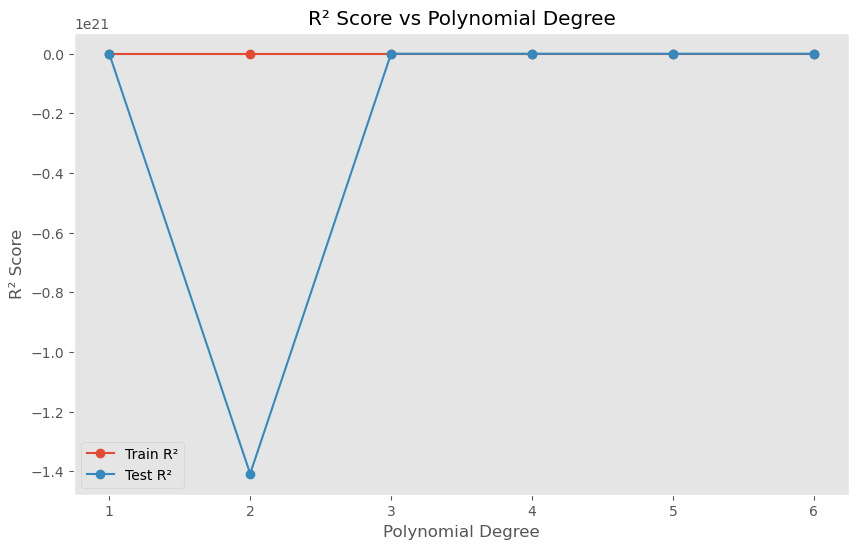

In [43]:
from sklearn.preprocessing import PolynomialFeatures

# Initialize lists to store R² scores
train_r2_scores = []
test_r2_scores = []
degrees = range(1, 7)

# Loop through degrees 1 to 6
for degree in degrees:
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    # Train the model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # Predict on training and test sets
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    
    # Calculate R² scores
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    # Append scores to the lists
    train_r2_scores.append(r2_train)
    test_r2_scores.append(r2_test)

# Print R² scores for each degree
for degree, r2_train, r2_test in zip(degrees, train_r2_scores, test_r2_scores):
    print(f"Degree {degree}: R² train = {r2_train:.3f}, R² test = {r2_test:.3f}")

# Plot the R² scores
plt.figure(figsize=(10, 6))
plt.plot(degrees, train_r2_scores, label='Train R²', marker='o')
plt.plot(degrees, test_r2_scores, label='Test R²', marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.title('R² Score vs Polynomial Degree')
plt.legend()
plt.grid()

## Ridge regression

Alpha 0.1: R² train = 0.517, R² test = 0.250
Alpha 0.2: R² train = 0.517, R² test = 0.250
Alpha 0.3: R² train = 0.517, R² test = 0.251
Alpha 0.4: R² train = 0.517, R² test = 0.251
Alpha 0.5: R² train = 0.517, R² test = 0.252
Alpha 0.6: R² train = 0.517, R² test = 0.252
Alpha 0.7: R² train = 0.517, R² test = 0.252
Alpha 0.8: R² train = 0.517, R² test = 0.253
Alpha 0.9: R² train = 0.517, R² test = 0.253
Alpha 1.0: R² train = 0.517, R² test = 0.254


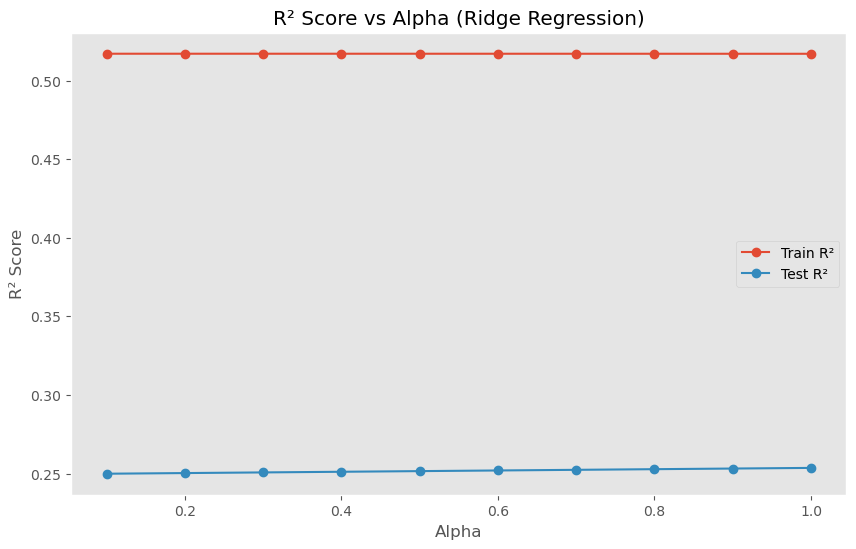

In [44]:
from sklearn.linear_model import Ridge

# Initialize lists to store R² scores
train_r2_scores = []
test_r2_scores = []
alphas = np.arange(0.1, 1.1, 0.1)

# Loop through alpha values
for alpha in alphas:
    # Train Ridge Regression model
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    
    # Predict on training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate R² scores
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    # Append scores to the lists
    train_r2_scores.append(r2_train)
    test_r2_scores.append(r2_test)

# Print R² scores for each alpha
for alpha, r2_train, r2_test in zip(alphas, train_r2_scores, test_r2_scores):
    print(f"Alpha {alpha:.1f}: R² train = {r2_train:.3f}, R² test = {r2_test:.3f}")

# Plot the R² scores
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_r2_scores, label='Train R²', marker='o')
plt.plot(alphas, test_r2_scores, label='Test R²', marker='o')
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title('R² Score vs Alpha (Ridge Regression)')
plt.legend()
plt.grid()
plt.show()

## Lasso regression

Alpha 0.1: R² train = 0.446, R² test = 0.244
Alpha 0.2: R² train = 0.358, R² test = 0.212
Alpha 0.3: R² train = 0.280, R² test = 0.186
Alpha 0.4: R² train = 0.190, R² test = 0.113
Alpha 0.5: R² train = 0.095, R² test = 0.043
Alpha 0.6: R² train = 0.000, R² test = -0.040
Alpha 0.7: R² train = 0.000, R² test = -0.040
Alpha 0.8: R² train = 0.000, R² test = -0.040
Alpha 0.9: R² train = 0.000, R² test = -0.040
Alpha 1.0: R² train = 0.000, R² test = -0.040


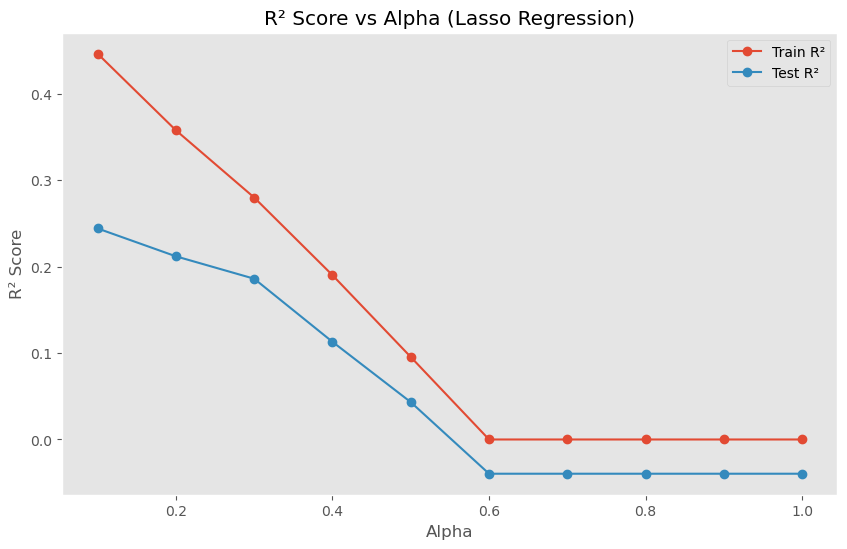

In [45]:
from sklearn.linear_model import Lasso

# Initialize lists to store R² scores
train_r2_scores = []
test_r2_scores = []
alphas = np.arange(0.1, 1.1, 0.1)

# Loop through alpha values
for alpha in alphas:
    # Train Lasso Regression model
    model = Lasso(alpha=alpha, max_iter=10000)  # Increased max_iter to ensure convergence
    model.fit(X_train, y_train)
    
    # Predict on training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate R² scores
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    # Append scores to the lists
    train_r2_scores.append(r2_train)
    test_r2_scores.append(r2_test)

# Print R² scores for each alpha
for alpha, r2_train, r2_test in zip(alphas, train_r2_scores, test_r2_scores):
    print(f"Alpha {alpha:.1f}: R² train = {r2_train:.3f}, R² test = {r2_test:.3f}")

# Plot the R² scores
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_r2_scores, label='Train R²', marker='o')
plt.plot(alphas, test_r2_scores, label='Test R²', marker='o')
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title('R² Score vs Alpha (Lasso Regression)')
plt.legend()
plt.grid()
plt.show()

## Elasticnet regression

In [46]:
from sklearn.linear_model import ElasticNet

# Initialize lists to store results
results = []

# Alpha and l1_ratio ranges
alphas = np.arange(0.1, 1.1, 0.1)
l1_ratios = np.arange(0.1, 1.1, 0.1)

# Loop through alpha and l1_ratio values
for alpha in alphas:
    for l1_ratio in l1_ratios:
        # Train ElasticNet Regression model
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)
        model.fit(X_train, y_train)
        
        # Predict on training and test sets
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Calculate R² scores
        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)
        
        # Append results
        results.append({'alpha': alpha, 'l1_ratio': l1_ratio, 'r2_train': r2_train, 'r2_test': r2_test})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

# Find the row with the maximum R² score for training
max_train_r2 = results_df.loc[results_df['r2_train'].idxmax()]
print("Maximum Train R²:")
print(max_train_r2)

# Find the row with the maximum R² score for testing
max_test_r2 = results_df.loc[results_df['r2_test'].idxmax()]
print("\nMaximum Test R²:")
print(max_test_r2)

    alpha  l1_ratio  r2_train   r2_test
0     0.1       0.1  0.510432  0.293938
1     0.1       0.2  0.505988  0.292326
2     0.1       0.3  0.500939  0.290847
3     0.1       0.4  0.495207  0.289280
4     0.1       0.5  0.488192  0.286098
5     0.1       0.6  0.479802  0.281208
6     0.1       0.7  0.472308  0.275591
7     0.1       0.8  0.464216  0.268273
8     0.1       0.9  0.455196  0.258485
9     0.1       1.0  0.446367  0.244181
10    0.2       0.1  0.496455  0.324116
11    0.2       0.2  0.484173  0.320236
12    0.2       0.3  0.469359  0.312790
13    0.2       0.4  0.453985  0.301699
14    0.2       0.5  0.437403  0.281255
15    0.2       0.6  0.418561  0.254348
16    0.2       0.7  0.405169  0.247062
17    0.2       0.8  0.389730  0.234870
18    0.2       0.9  0.372447  0.218446
19    0.2       1.0  0.357757  0.211938
20    0.3       0.1  0.479436  0.343306
21    0.3       0.2  0.458399  0.332835
22    0.3       0.3  0.435040  0.312887
23    0.3       0.4  0.408315  0.278456


## Support Vector Regression (SVR)

In [47]:
from sklearn.svm import SVR

# Initialize lists to store results
results = []

# Range of C and epsilon values
C_values = np.arange(1, 7, 1)
epsilon_values = np.arange(0.1, 1.2, 0.1)

# Loop through C and epsilon values
for C in C_values:
    for epsilon in epsilon_values:
        # Train SVR model
        model = SVR(C=C, epsilon=epsilon)
        model.fit(X_train, y_train.ravel())  # Flatten y for SVR compatibility
        
        # Predict on training and test sets
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Calculate R² scores
        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)
        
        # Append results
        results.append({'C': C, 'epsilon': epsilon, 'r2_train': r2_train, 'r2_test': r2_test})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

# Find the best combination for training and testing
max_train_r2 = results_df.loc[results_df['r2_train'].idxmax()]
max_test_r2 = results_df.loc[results_df['r2_test'].idxmax()]

print("\nMaximum Train R²:")
print(max_train_r2)

print("\nMaximum Test R²:")
print(max_test_r2)

    C  epsilon  r2_train   r2_test
0   1      0.1  0.800767  0.489052
1   1      0.2  0.795069  0.443310
2   1      0.3  0.777027  0.330993
3   1      0.4  0.752844  0.326511
4   1      0.5  0.718498  0.227110
5   1      0.6  0.661513  0.064592
6   1      0.7  0.570456 -0.110666
7   1      0.8  0.465749 -0.313254
8   1      0.9  0.350932 -0.628646
9   1      1.0  0.201814 -0.971234
10  1      1.1  0.025247 -1.339481
11  2      0.1  0.814502  0.190381
12  2      0.2  0.806819  0.229159
13  2      0.3  0.795777  0.260046
14  2      0.4  0.773608  0.158537
15  2      0.5  0.741251  0.118960
16  2      0.6  0.678729 -0.006357
17  2      0.7  0.599213 -0.189427
18  2      0.8  0.509134 -0.474571
19  2      0.9  0.384633 -0.769967
20  2      1.0  0.239465 -1.067643
21  2      1.1  0.078572 -1.402873
22  3      0.1  0.814768  0.121532
23  3      0.2  0.811286  0.141155
24  3      0.3  0.799522  0.174988
25  3      0.4  0.774873  0.166118
26  3      0.5  0.744747  0.033746
27  3      0.6  0.69

## Deicision tree regression

In [48]:
from sklearn.tree import DecisionTreeRegressor

# Initialize the Decision Tree Regressor
model = DecisionTreeRegressor()

# Train the model
model.fit(X_train, y_train)

# Predict on training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate R² scores
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the R² scores
print(f"R² score for training set: {r2_train:.3f}")
print(f"R² score for test set: {r2_test:.3f}")

R² score for training set: 0.830
R² score for test set: 0.345


## Random forest regression

In [49]:
from sklearn.ensemble import RandomForestRegressor

# Initialize lists to store results
results = []

# Range of n_estimators
n_estimators_range = range(100, 401, 10)

# Loop through n_estimators values
for n_estimators in n_estimators_range:
    # Train Random Forest Regressor
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train.ravel())  # Flatten y for compatibility
    
    # Predict on training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate R² scores
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    # Append results
    results.append({'n_estimators': n_estimators, 'r2_train': r2_train, 'r2_test': r2_test})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results
print("Top 10 configurations by Test R²:")
print(results_df.sort_values(by='r2_test', ascending=False).head(10))

Top 10 configurations by Test R²:
    n_estimators  r2_train   r2_test
25           350  0.828392  0.359303
26           360  0.828359  0.359234
27           370  0.828390  0.357655
24           340  0.828311  0.356541
28           380  0.828331  0.355771
21           310  0.828337  0.354332
29           390  0.828292  0.353939
30           400  0.828345  0.353435
23           330  0.828340  0.353361
22           320  0.828388  0.352090


## Gradient boosting regression

In [50]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize lists to store results
results = []

# Hyperparameter ranges
n_estimators_range = range(100, 311, 10)
learning_rate_range = np.arange(0.1, 1.1, 0.1)
max_depth_range = range(1, 16)

# Perform grid search over hyperparameters
for n_estimators in n_estimators_range:
    for learning_rate in learning_rate_range:
        for max_depth in max_depth_range:
            # Train Gradient Boosting Regressor
            model = GradientBoostingRegressor(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth
            )
            model.fit(X_train, y_train.ravel())  # Flatten y for compatibility
            
            # Predict on training and test sets
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            
            # Calculate R² scores
            r2_train = r2_score(y_train, y_train_pred)
            r2_test = r2_score(y_test, y_test_pred)
            
            # Append results
            results.append({
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'r2_train': r2_train,
                'r2_test': r2_test
            })

# Print the top results sorted by test R²
print("Top 10 configurations by Test R²:")
print(results_df.sort_values(by='r2_test', ascending=False).head(10))

Top 10 configurations by Test R²:
    n_estimators  r2_train   r2_test
25           350  0.828392  0.359303
26           360  0.828359  0.359234
27           370  0.828390  0.357655
24           340  0.828311  0.356541
28           380  0.828331  0.355771
21           310  0.828337  0.354332
29           390  0.828292  0.353939
30           400  0.828345  0.353435
23           330  0.828340  0.353361
22           320  0.828388  0.352090


## K-nearest Neighbors Regression

In [51]:
from sklearn.neighbors import KNeighborsRegressor

# Initialize lists to store results
results = []

# Range of n_neighbors
n_neighbors_range = range(1, 17)

# Loop through n_neighbors values
for n_neighbors in n_neighbors_range:
    # Train K-Nearest Neighbors Regressor
    model = KNeighborsRegressor(n_neighbors=n_neighbors)
    model.fit(X_train, y_train.ravel())  # Flatten y for compatibility
    
    # Predict on training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate R² scores
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    # Append results
    results.append({'n_neighbors': n_neighbors, 'r2_train': r2_train, 'r2_test': r2_test})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results
print("Top configurations by Test R²:")
print(results_df.sort_values(by='r2_test', ascending=False).head(10))

Top configurations by Test R²:
    n_neighbors  r2_train   r2_test
11           12  0.622589  0.563431
13           14  0.569980  0.559134
12           13  0.585739  0.552068
10           11  0.671771  0.551224
3             4  0.798011  0.550164
15           16  0.497215  0.549129
9            10  0.690831  0.545629
0             1  0.785036  0.543855
14           15  0.528268  0.540134
8             9  0.720971  0.496742


## XGBregression

In [52]:
from xgboost import XGBRegressor

# Initialize lists to store results
results = []

# Hyperparameter ranges
n_estimators_range = range(100, 311, 10)
learning_rate_range = np.arange(0.1, 1.1, 0.1)
max_depth_range = range(1, 17)

# Perform grid search over hyperparameters
for n_estimators in n_estimators_range:
    for learning_rate in learning_rate_range:
        for max_depth in max_depth_range:
            # Train XGBoost Regressor
            model = XGBRegressor(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                random_state=42
            )
            model.fit(X_train, y_train.ravel())  # Flatten y for compatibility
            
            # Predict on training and test sets
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            
            # Calculate R² scores
            r2_train = r2_score(y_train, y_train_pred)
            r2_test = r2_score(y_test, y_test_pred)
            
            # Append results
            results.append({
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'r2_train': r2_train,
                'r2_test': r2_test
            })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the top 10 configurations sorted by test R²
print("Top 10 configurations by Test R²:")
print(results_df.sort_values(by='r2_test', ascending=False).head(10))

Top 10 configurations by Test R²:
      n_estimators  learning_rate  max_depth  r2_train   r2_test
162            110            0.1          3  0.829460  0.350879
322            120            0.1          3  0.829509  0.350678
2              100            0.1          3  0.829391  0.350649
482            130            0.1          3  0.829558  0.350111
642            140            0.1          3  0.829604  0.349352
802            150            0.1          3  0.829653  0.349190
1922           220            0.1          3  0.829753  0.348917
18             100            0.2          3  0.829744  0.348848
2082           230            0.1          3  0.829758  0.348825
962            160            0.1          3  0.829678  0.348701


## Adaboost regression

In [53]:
from sklearn.ensemble import AdaBoostRegressor

# Initialize lists to store results
results = []

# Hyperparameter ranges
n_estimators_range = range(100, 311, 10)
learning_rate_range = np.arange(0.1, 1.1, 0.1)
max_depth_range = range(1, 17)

# Perform grid search over hyperparameters
for n_estimators in n_estimators_range:
    for learning_rate in learning_rate_range:
        for max_depth in max_depth_range:
            # Define the AdaBoost model with a DecisionTreeRegressor as the base learner
            model = AdaBoostRegressor(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                random_state=42
            )
            
            # Train the model
            model.fit(X_train, y_train.ravel())
            
            # Predict on training and test sets
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            
            # Calculate R² scores
            r2_train = r2_score(y_train, y_train_pred)
            r2_test = r2_score(y_test, y_test_pred)
            
            # Append results
            results.append({
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'r2_train': r2_train,
                'r2_test': r2_test
            })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the top 10 configurations sorted by test R²

print("Top 10 configurations by Test R²:")
print(results_df.sort_values(by='r2_test', ascending=False).head(10))

Top 10 configurations by Test R²:
      n_estimators  learning_rate  max_depth  r2_train   r2_test
0              100            0.1          1  0.772291  0.748715
321            120            0.1          2  0.772291  0.748715
1287           180            0.1          8  0.772291  0.748715
1288           180            0.1          9  0.772291  0.748715
1289           180            0.1         10  0.772291  0.748715
1290           180            0.1         11  0.772291  0.748715
1291           180            0.1         12  0.772291  0.748715
1292           180            0.1         13  0.772291  0.748715
1293           180            0.1         14  0.772291  0.748715
1294           180            0.1         15  0.772291  0.748715


## K-fold validation with Adaboost regression

In [54]:
from sklearn.model_selection import KFold

# Range of K-Fold splits to evaluate
k_values = range(2, 11)  # From K=2 to K=10 (K=1 is invalid for cross-validation)

# Lists to store results for each K
results = []

# Iterate over different K values
for k in k_values:
    # Initialize K-Fold Cross-Validation
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    # Initialize lists to store R² scores for this K
    train_r2_scores = []
    test_r2_scores = []
    
    # Define the AdaBoost Regressor
    model = AdaBoostRegressor(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    )
    
    # Perform cross-validation
    for train_index, test_index in kf.split(DPP_DTT_X):
        # Split data into training and test sets
        X_train, X_test = scaler_X.fit_transform(DPP_DTT_X.iloc[train_index]), scaler_X.transform(DPP_DTT_X.iloc[test_index])
        y_train, y_test = scaler_y.fit_transform(DPP_DTT_Y.iloc[train_index]), scaler_y.transform(DPP_DTT_Y.iloc[test_index])
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on training and test sets
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Calculate R² scores
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        # Append scores
        train_r2_scores.append(train_r2)
        test_r2_scores.append(test_r2)
    
    # Store average R² scores for this K
    results.append({
        'K': k,
        'Avg Train R²': np.mean(train_r2_scores),
        'Avg Test R²': np.mean(test_r2_scores)
    })

# Convert results to a DataFrame for better readability
results_df = pd.DataFrame(results)

# Print the results
print("K-Fold Cross-Validation Results:")
print(results_df)

C:\Users\Myeongyeon Lee\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Myeongyeon Lee\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Myeongyeon Lee\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Myeongyeon Lee\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

K-Fold Cross-Validation Results:
    K  Avg Train R²  Avg Test R²
0   2      0.824376     0.674989
1   3      0.786438     0.772795
2   4      0.785548     0.781127
3   5      0.783777     0.747490
4   6      0.781450     0.696546
5   7      0.781739     0.676530
6   8      0.780830     0.715180
7   9      0.779165     0.673391
8  10      0.779663     0.527358
